# Analysis production and production loss - Stockholm facility

In [ ]:
#adjust notebook size
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [11]:
# import some libraries to work with
import sys
sys.path.append('packages')
from best_distribution import best_distribution as bd
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
import statistics
import seaborn as sns
import scipy.stats
import numpy as np

##### retrieve the max sustainable rate ophalen from the data

In [55]:
# get the max sustainable rate for Stockholm
msr_df = pd.read_json('../data/master_data.json', typ='series')

In [54]:
# store the max sustainable rate for Stockholm in a variable for later use
msr_stockholm = msr_df['STO msr']

274

##### retrieve the data for Stockholm

In [7]:
# get the stockholm data 
stockholm = list()
for bestandsnaam in os.listdir('../data/daily_production/STO/'):
    data = pd.read_json('../data/daily_production/STO/'+bestandsnaam, typ='series')
    row = pd.Series(data)
    stockholm.append(row)
    stockholm_data= pd.DataFrame(stockholm)

In [8]:
# short check if this is the data that we can work with
stockholm_data

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Tuesday,1,0,09-22-2020 00:00:00.0000,No,85,31,189
1,Monday,1,0,01-22-2018 00:00:00.0000,No,51,19,223
2,Wednesday,1,0,08-21-2019 00:00:00.0000,No,110,40,164
3,Tuesday,1,0,08-21-2018 00:00:00.0000,Yes,#MV,#MV,#MV
4,Wednesday,1,0,09-22-2021 00:00:00.0000,No,134,49,140
...,...,...,...,...,...,...,...,...
1825,Friday,1,0,07-29-2022 00:00:00.0000,No,274,100,0
1826,Monday,1,0,07-20-2020 00:00:00.0000,No,81,29,193
1827,Sunday,1,0,06-23-2019 00:00:00.0000,No,72,26,202
1828,Saturday,1,0,06-23-2018 00:00:00.0000,No,77,28,197


In [12]:
# derrive a new variable from the panda dataframe
stockholm_data_nulls = stockholm_data

##### check for null values and where they orginate from

- observation 1: in Stockholm, as in Brussels there is no #MV when there is no maintenance.
    - Meaning that when there is no maintenance, there is always production or production loss data.
- observation 2: we have no data if the maintenance is scheduled or not, we only notice that there is no data on days marked with maintenance 'yes'
    - we can determine for certain that in Stockholm there is no other recording than at hour 1 of the day there is no registration of maintenance on other timestamps

In [26]:
# let's check the fields that are marked with maintenance 'yes'
for index, field in stockholm_data_nulls.iterrows() :
    if field['maintenance']=="Yes":
        display(field)

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-21-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 3, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              07-19-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 39, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              07-08-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 52, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-03-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 61, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-15-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 98, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              07-23-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 100, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              07-12-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 110, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              07-15-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 139, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-23-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 143, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              07-04-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 150, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-06-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 169, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-06-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 175, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-17-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 193, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-10-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 214, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-19-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 220, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-11-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 227, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-18-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 233, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-16-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 261, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-07-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 275, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              07-05-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 288, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-22-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 299, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              07-14-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 314, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              07-13-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 342, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              07-22-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 352, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-14-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 361, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-02-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 403, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              07-09-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 409, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              07-18-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 421, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-20-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 451, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              07-14-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 457, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              07-13-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 495, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-25-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 501, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              07-02-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 509, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-09-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 531, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-11-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 546, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-07-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 559, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              07-29-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 563, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              07-29-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 564, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-16-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 572, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              07-18-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 590, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-05-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 635, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-13-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 678, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              07-25-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 682, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              07-24-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 686, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-12-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 694, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-04-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 731, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-28-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 750, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              07-19-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 776, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-26-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 781, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              07-28-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 803, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-06-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 815, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-10-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 832, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-01-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 837, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-01-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 842, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-08-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 846, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              07-03-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 862, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-24-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 870, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              07-15-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 902, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-14-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 920, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-05-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 933, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-13-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 945, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-02-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 968, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-02-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 969, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-27-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 990, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              07-16-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1030, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              07-27-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1036, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-11-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1041, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-09-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1055, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              07-20-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1060, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              07-31-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1074, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              07-31-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1078, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-07-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1080, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-25-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1142, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-24-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1152, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-06-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1194, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              07-30-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1208, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              07-30-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1212, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-08-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1225, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-10-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1239, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              07-26-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1246, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              07-17-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1260, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              08-26-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1296, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              07-01-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1306, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-03-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1325, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-03-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1326, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-12-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1328, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-15-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1367, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              07-21-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1377, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-17-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1380, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-19-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1408, dtype: object

DoW                                 Monday
hour                                     1
minute                                   0
date              08-01-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1422, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-08-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1425, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-23-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1474, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-12-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1490, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-15-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1511, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-04-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1528, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-04-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1529, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              07-06-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1547, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-21-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1554, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              07-17-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1555, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              07-10-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1594, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              07-11-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1606, dtype: object

DoW                                 Friday
hour                                     1
minute                                   0
date              07-16-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1630, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-20-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1643, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              07-07-2019 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1653, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-05-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1670, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-05-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1671, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-14-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1684, dtype: object

DoW                               Thursday
hour                                     1
minute                                   0
date              08-13-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1719, dtype: object

DoW                              Wednesday
hour                                     1
minute                                   0
date              08-22-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1725, dtype: object

DoW                                 Sunday
hour                                     1
minute                                   0
date              08-09-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1782, dtype: object

DoW                               Saturday
hour                                     1
minute                                   0
date              08-18-2018 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1792, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              08-16-2022 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1820, dtype: object

DoW                                Tuesday
hour                                     1
minute                                   0
date              07-20-2021 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             #MV
Name: 1829, dtype: object

In [27]:
# check if there is #MV values when maintenance is not 'yes'
for index, field in stockholm_data_nulls.iterrows() :
    if  field['production']=='#MV' and field['maintenance']!="Yes":
        display(field)

In [28]:
# check if maintenance is set on other timestamps than 1
for index, field in stockholm_data_nulls.iterrows() :
    if field['maintenance']=="Yes" and field['hour'] !=1:
        display(field)

##### first couple of conclusions:

- to make a prediction of the production capability of brussels  we can remove the rows where the record is marked with maintenance yes, since the task is to make a simulation, not to check for optimalisations in maintenance
- we can make the #MV values as 0 and plot them to see when the specific timings of maintenance occur (if there is time left)

In [13]:
# creating a new df with the dropped the #MV records 
stockholm_data_wo_nulls = stockholm_data.replace({"#MV": np.nan}).dropna()

In [14]:
# check the dataframe
display(stockholm_data_wo_nulls)

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Tuesday,1,0,09-22-2020 00:00:00.0000,No,85.0,31.0,189.0
1,Monday,1,0,01-22-2018 00:00:00.0000,No,51.0,19.0,223.0
2,Wednesday,1,0,08-21-2019 00:00:00.0000,No,110.0,40.0,164.0
4,Wednesday,1,0,09-22-2021 00:00:00.0000,No,134.0,49.0,140.0
5,Tuesday,1,0,01-22-2019 00:00:00.0000,No,55.0,20.0,219.0
...,...,...,...,...,...,...,...,...
1824,Sunday,1,0,12-11-2022 00:00:00.0000,No,47.0,17.0,227.0
1825,Friday,1,0,07-29-2022 00:00:00.0000,No,274.0,100.0,0.0
1826,Monday,1,0,07-20-2020 00:00:00.0000,No,81.0,29.0,193.0
1827,Sunday,1,0,06-23-2019 00:00:00.0000,No,72.0,26.0,202.0


In [15]:
# let's set the objects to ints so we can use them for the graphs
stockholm_data_wo_nulls['production'] = stockholm_data_wo_nulls['production'].astype(int)
stockholm_data_wo_nulls['prod_loss']  = stockholm_data_wo_nulls['prod_loss'].astype(int)
# percentage is not used but we int it anyway just to do a describe of the dataframe
stockholm_data_wo_nulls['prod_loss_perc']  = stockholm_data_wo_nulls['prod_loss_perc'].astype(int)

In [16]:
# let's describe the dataset
stockholm_data_wo_nulls.describe()

,hour,minute,prod_loss,prod_loss_perc,production
count,1716.0,1716.0,1716.000000,1716.000000,1716.000000
mean,1.0,0.0,97.054196,35.429487,176.945804
std,0.0,0.0,63.080946,23.018391,63.080946
min,1.0,0.0,9.000000,3.000000,0.000000
25%,1.0,0.0,62.750000,23.000000,182.000000
50%,1.0,0.0,73.000000,27.000000,201.000000
75%,1.0,0.0,92.000000,33.250000,211.250000
max,1.0,0.0,274.000000,100.000000,265.000000


In [17]:
# let's separate the production and production loss into pandas series 
stockholm_production_wo_nulls  =stockholm_data_wo_nulls['production']
stockholm_prod_loss_wo_nulls  =stockholm_data_wo_nulls['prod_loss']

##### visualize the data  for production and production loss 

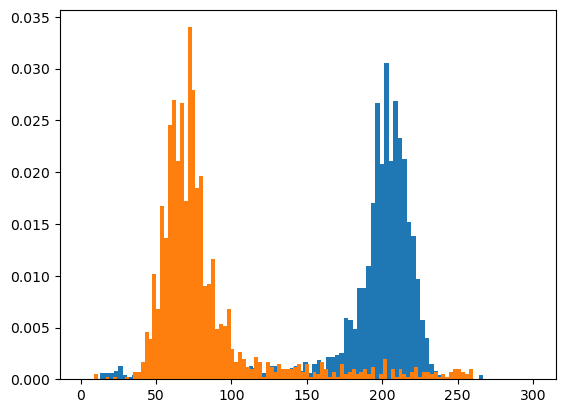

In [30]:
# make a hist plot of the production and the production loss
# let's the zeros from the histview on the distribution 
# we can see a nice pattern emerging around the 1000 for production and around 250 for production loss
plt.hist(stockholm_production_wo_nulls,range=(1,300),bins=100, density = True);
plt.hist(stockholm_prod_loss_wo_nulls,range=(1,260),bins=100, density = True);

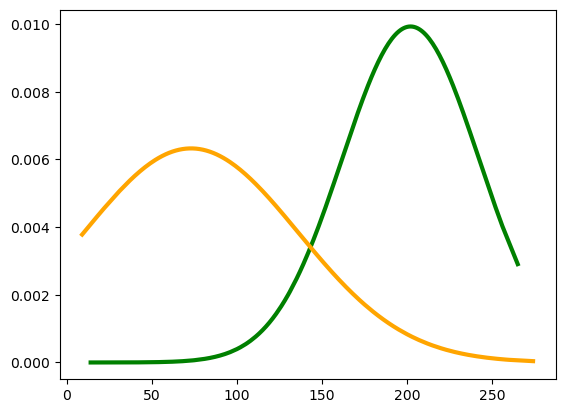

In [20]:
# let's make a nicer plot to see how the distribution look like

x_axis = (stockholm_production_wo_nulls.replace({0: np.nan}).dropna(axis=0)).sort_values()
x_axis_2 = (stockholm_prod_loss_wo_nulls.replace({0: np.nan}).dropna(axis=0)).sort_values()
# Calculating mean and standard deviation 
mean = statistics.mean(x_axis) 
sd = statistics.stdev(x_axis) 
mdian = statistics.median(x_axis)
mean_2 = statistics.mean(x_axis_2) 
sd_2 = statistics.stdev(x_axis_2) 
mdian_2 = statistics.median(x_axis_2)
plt.plot(x_axis, norm.pdf(x_axis, mdian, sd),color='green', linewidth=3) 
plt.plot(x_axis_2, norm.pdf(x_axis_2, mdian_2, sd_2),color='orange', linewidth=3) 
plt.show()

### detailed production analysis

176.9458041958042 is the mean
201.0 is the median
Variance: 3976.8869229546835
63.06256356155106 is the standard deviation
negative skew


/Users/geertvanderkrieken/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/geertvanderkrieken/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


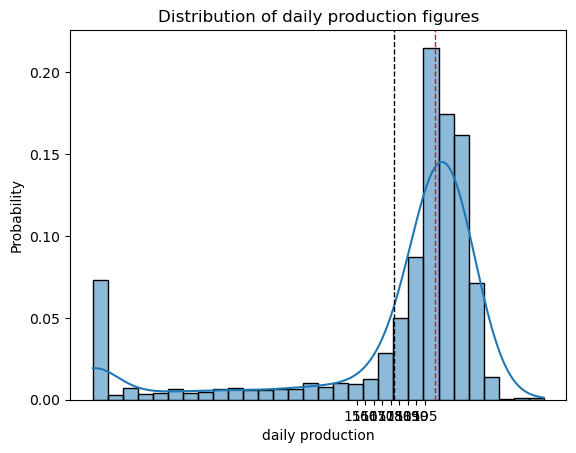

In [50]:
# based on everything above we make a better plot for production data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this

display_production_data_stockholm = stockholm_production_wo_nulls.sort_values()

production_mean = display_production_data_stockholm.mean()
production_median = np.median(display_production_data_stockholm)
production_std = statistics.pstdev(display_production_data_stockholm)
production_variance = np.var(display_production_data_stockholm)
skew = ("negative skew" 
        if np.median(display_production_data_stockholm)-display_production_data_stockholm.mean()>0 
        else "positive skew")

# numpy_data = np.random.normal(data_mean, data_std)
# numpy_data = (numpy_data - data_mean)/data_std


sns.histplot(display_production_data_stockholm, bins=30, kde=True, stat='probability')
plt.axvline(production_mean, color='black', linestyle='dashed', linewidth=1)
plt. axvline(production_median, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production')
plt.ylabel('Probability')
plt.title("Distribution of daily production figures")
plt.xticks(range(155,200,5))
print(f'{production_mean} is the mean')
print(f'{production_median} is the median')
print(f"Variance: {production_variance}")
print(f'{production_std} is the standard deviation')
print(f'{skew}')
plt.show()



In [22]:

# let's use the shared function to doublecheck the results
best_distribution, best_params = bd.find_best_fit_distribution_continuous(stockholm_production_wo_nulls)
 

# Print the best-fit distribution and its parameters
print(f"Best-fit distribution: {best_distribution.name}")
print(f"Parameters: {best_params}")

Best-fit distribution: norm
Parameters: (176.9458041958042, 63.062563561551066)


##### simulation for the production

In [23]:
# set the number of days and capture the returned list from the function
aantal_dagen=10
voorspellingen_production = bd.simulatie(production_mean, production_std, msr_stockholm,aantal_dagen)
totaal =0
print(f'de volgende {aantal_dagen} dagen is dit de mogelijke productie: ')
for voorspelling in voorspellingen_production:
    print (f' {voorspelling}')
    totaal +=voorspelling
print(f'de mogelijke hoeveelheid productie voor de volgende {aantal_dagen} dagen is: {totaal}')

de volgende 10 dagen is dit de mogelijke productie: 
 166
 182
 88
 164
 137
 108
 192
 136
 235
 108
de mogelijke hoeveelheid productie voor de volgende 10 dagen is: 1516


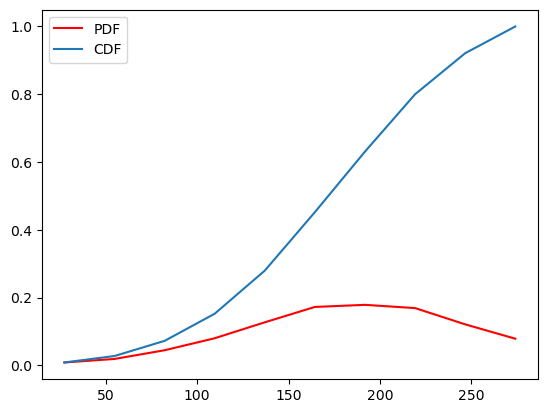

In [24]:
# pdf = probability distribution function, cdf= cumulative distribution function
cdf_data = bd.simulatie(production_mean, production_std, msr_stockholm,10**5)
count, bins_count = np.histogram(cdf_data, bins=10) 
  
# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.legend() 

Text(0, 0.5, '$p$')

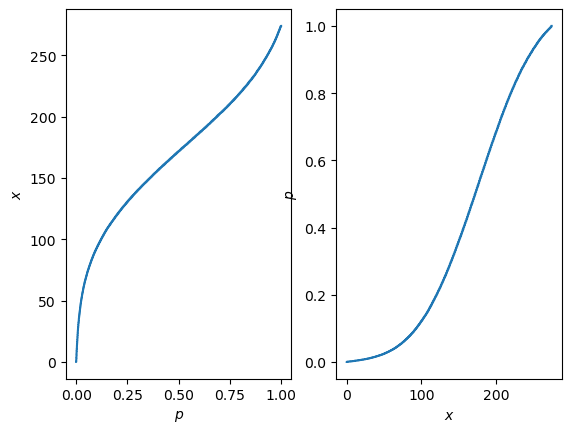

In [47]:
# example found on stack overflow, cumulative distribution function

cdf_data = bd.simulatie(production_mean, production_std, msr_stockholm,10**5)
cdf_data_sorted = np.sort(cdf_data)

p = 1. * np.arange(len(cdf_data)) / (len(cdf_data) - 1)

# plot the sorted data:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(p, cdf_data_sorted)
ax1.set_xlabel('$p$')
ax1.set_ylabel('$x$')

ax2 = fig.add_subplot(122)
ax2.plot(cdf_data_sorted, p)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$p$')

### detailed production loss analysis

97.0541958041958 is the mean
73.0 is the median
Variance: 3976.8869229546553
63.06256356155106 is the standard deviation
positive skew


/Users/geertvanderkrieken/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/geertvanderkrieken/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


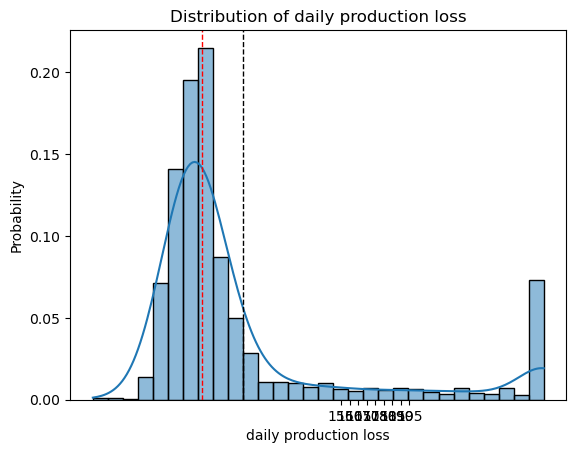

In [36]:
# based on everything above we make a better plot for production loss data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this
data_to_display_prod_loss = stockholm_prod_loss_wo_nulls.sort_values()

# with the above figures I can recreate a normal distribution with numpy:
prod_loss_mean = data_to_display_prod_loss.mean()
prod_loss_median = np.median(data_to_display_prod_loss)
prod_loss_std = statistics.pstdev(data_to_display_prod_loss)
prod_loss_var = np.var(data_to_display_prod_loss)
skew = "negative skew" if np.median(data_to_display_prod_loss)-data_to_display_prod_loss.mean()>0 else "positive skew"

#numpy_data_prod_loss = np.random.normal(data_mean_prod_loss, data_std_prod_loss)
#numpy_data_prod_loss = (numpy_data_prod_loss - data_mean_prod_loss)/data_std_prod_loss

sns.histplot(data_to_display_prod_loss, bins=30, kde=True, stat='probability')
plt.axvline(prod_loss_mean, color='black', linestyle='dashed', linewidth=1)
plt. axvline(prod_loss_median, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production loss')
plt.ylabel('Probability')
plt.title("Distribution of daily production loss")
plt.xticks(range(155,200,5))
print(f'{prod_loss_mean} is the mean')
print(f'{prod_loss_median} is the median')
print(f"Variance: {prod_loss_var}")
print(f'{prod_loss_std} is the standard deviation')
print(f'{skew}')
plt.show()

##### simulation for the production loss

In [49]:
aantal_dagen= 7
voorspellingen_production_verlies = bd.simulatie(prod_loss_mean, prod_loss_std, msr_stockholm, aantal_dagen)
totaal =0
print(f'de volgende {aantal_dagen} dagen is dit het mogelijke productie verlies: ')
for voorspelling in voorspellingen_production_verlies:
    print (f' {voorspelling}')
    totaal +=voorspelling
print(f'de mogelijke hoeveelheid productie verlies voor de volgende {aantal_dagen} dagen is: {totaal}')

de volgende 7 dagen is dit het mogelijke productie verlies: 
 416
 350
 428
 149
 163
 269
 180
de mogelijke hoeveelheid productie verlies voor de volgende 7 dagen is: 1955


### details production loss percent

- could be used to make some better prediction on production loss, but not used for now

In [32]:
stockholm_prod_loss_perc_wo_nulls  =stockholm_data_wo_nulls['prod_loss_perc']

In [33]:
stockholm_prod_loss_perc_wo_nulls.describe()

count    1716.000000
mean       35.429487
std        23.018391
min         3.000000
25%        23.000000
50%        27.000000
75%        33.250000
max       100.000000
Name: prod_loss_perc, dtype: float64

35.42948717948718 is the mean
27.0 is the median
Variance: 529.5375687346826
23.011683309455744 is the standard deviation
positive skew


/Users/geertvanderkrieken/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/geertvanderkrieken/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


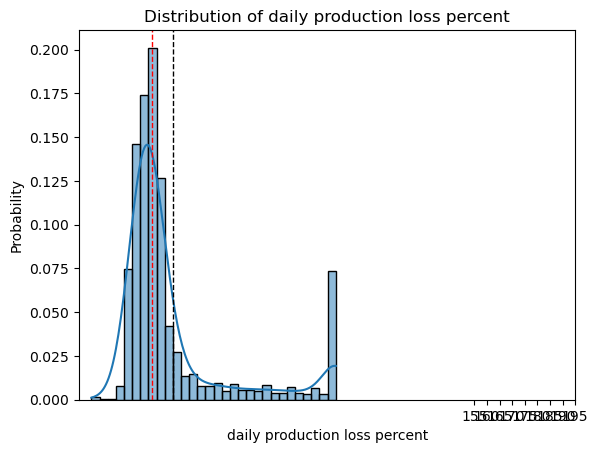

In [35]:
# based on everything above we make a better plot for production loss data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this
data_to_display_prod_loss_perc = stockholm_prod_loss_perc_wo_nulls.sort_values()

# with the above figures I can recreate a normal distribution with numpy:
prod_loss_perc_mean = data_to_display_prod_loss_perc.mean()
prod_loss_perc_median = np.median(data_to_display_prod_loss_perc)
prod_loss_perc_std = statistics.pstdev(data_to_display_prod_loss_perc)
prod_loss_perc_var = np.var(data_to_display_prod_loss_perc)
skew_prod_loss_perc = "negative skew" if np.median(data_to_display_prod_loss_perc)-data_to_display_prod_loss_perc.mean()>0 else "positive skew"

#numpy_data_prod_loss = np.random.normal(data_mean_prod_loss, data_std_prod_loss)
#numpy_data_prod_loss = (numpy_data_prod_loss - data_mean_prod_loss)/data_std_prod_loss

sns.histplot(data_to_display_prod_loss_perc, bins=30, kde=True, stat='probability')
plt.axvline(prod_loss_perc_mean, color='black', linestyle='dashed', linewidth=1)
plt. axvline(prod_loss_perc_median, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production loss percent')
plt.ylabel('Probability')
plt.title("Distribution of daily production loss percent")
plt.xticks(range(155,200,5))
print(f'{prod_loss_perc_mean} is the mean')
print(f'{prod_loss_perc_median} is the median')
print(f"Variance: {prod_loss_perc_var}")
print(f'{prod_loss_perc_std} is the standard deviation')
print(f'{skew_prod_loss_perc}')
plt.show()